# Imports

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt

# Pre-Processing

In [9]:
# Load and combine data
PATH_TO_FILE = "../raw data/aapl_2016_2020.csv"
df = pd.read_csv(PATH_TO_FILE, low_memory=False)
df.columns = df.columns.str.strip()

# Option type
option_type = "put"

# Convert Unix timestamps to datetime
df['QUOTE_DATETIME'] = pd.to_datetime(df['[QUOTE_UNIXTIME]'], unit='s')
df['EXPIRE_DATETIME'] = pd.to_datetime(df['[EXPIRE_UNIX]'], unit='s')

# Load underlying price data for volatility computation
underlying_prices = df[['QUOTE_DATETIME', '[UNDERLYING_LAST]']].drop_duplicates().set_index('QUOTE_DATETIME').sort_index()

# Function to compute historical volatility
def historical_volatility(series, window=20):
    return np.sqrt(252) * series.pct_change().rolling(window=window).std()

# Compute 20-day historical volatility
underlying_prices['hist_vol_20d'] = historical_volatility(underlying_prices['[UNDERLYING_LAST]'])
underlying_prices.dropna(inplace=True)

# Merge historical volatility back into main dataframe
df = df.merge(underlying_prices[['hist_vol_20d']], left_on='QUOTE_DATETIME', right_index=True, how='inner')

# Columns to numeric conversion: choose columns based on option type
if option_type == 'call':
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]',
                    '[C_THETA]', '[C_RHO]', '[C_BID]', '[C_ASK]']
else:
    numeric_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]',
                    '[P_THETA]', '[P_RHO]', '[P_BID]', '[P_ASK]']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Calculate mid-price based on option type
if option_type == 'call':
    df['CALL_EQUI_PRICE'] = (df['[C_BID]'] + df['[C_ASK]']) / 2
else:
    df['PUT_EQUI_PRICE'] = (df['[P_BID]'] + df['[P_ASK]']) / 2

# Drop rows with missing essential data (dynamically chosen based on option type)
essential_cols = ['[UNDERLYING_LAST]', '[DTE]', '[STRIKE]', 'hist_vol_20d']
if option_type == 'call':
    essential_cols.append('CALL_EQUI_PRICE')
else:
    essential_cols.append('PUT_EQUI_PRICE')
df.dropna(subset=essential_cols, inplace=True)

# Prepare option data based on the option type
if option_type == 'call':
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[C_DELTA]', '[C_GAMMA]', '[C_VEGA]', '[C_THETA]', '[C_RHO]', 'CALL_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_calls_data.csv'
    model_file = 'option_pricing_mlp_model_call.h5'
else:
    option_cols = ['[UNDERLYING_LAST]', '[STRIKE]', '[DTE]', 'hist_vol_20d', 
                   '[P_DELTA]', '[P_GAMMA]', '[P_VEGA]', '[P_THETA]', '[P_RHO]', 'PUT_EQUI_PRICE']
    col_rename = ['underlying_price', 'strike_price', 'days_to_expiry', 'hist_volatility', 
                  'delta', 'gamma', 'vega', 'theta', 'rho', 'equilibrium_price']
    output_file = 'processed_puts_data.csv'
    model_file = 'option_pricing_mlp_model_put.h5'

option_df = df[option_cols].copy()
option_df.columns = col_rename

# Normalize strike price and compute time to expiry in years
option_df['strike_price'] = option_df['strike_price'] / 1000
option_df['time_to_expiry'] = option_df['days_to_expiry'] / 365
option_df.drop('days_to_expiry', axis=1, inplace=True)

# Save the processed option data to CSV, uncomment if needed
# option_df.to_csv(output_file, index=False)

# Hyperparameters

In [10]:
# Hyperparameters
n_units_per_layer = [256, 256, 256, 1]
layers = 4
n_batch = 1024
n_epochs = 3

# Building model

In [11]:
# Prepare data for modeling
X = option_df[['underlying_price', 'strike_price', 'hist_volatility', 'delta', 'gamma', 'vega', 'theta', 'rho', 'time_to_expiry']]
y = option_df['equilibrium_price']


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model 
model = Sequential()

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add first layer
model.add(Dense(n_units_per_layer[0], activation='relu', input_shape=(X_train_scaled.shape[1],)))

for i in range(1, layers):
# Define Keras MLP model
    model.add(Dense(n_units_per_layer[i], activation='relu'))

# Learning rate scheduling
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.1  # reduce LR by 10x every 10 epochs
    return lr

lr_callback = LearningRateScheduler(scheduler)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,401 (525.00 KB)

 Trainable params: 134,401 (525.00 KB)

 Non-trainable params: 0 (0.00 B)

# Train model

In [12]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=n_batch, validation_split=0.2, verbose=1, callbacks=[lr_callback])

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test MAE: {mae}")

Epoch 1/3
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 422.8032 - mae: 7.5092 - val_loss: 1.7320 - val_mae: 0.7317 - learning_rate: 0.0010
Epoch 2/3
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4342 - mae: 0.6536 - val_loss: 0.9587 - val_mae: 0.5297 - learning_rate: 0.0010
Epoch 3/3
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9153 - mae: 0.5019 - val_loss: 0.7534 - val_mae: 0.4735 - learning_rate: 0.0010
6260/6260 ━━━━━━━━━━━━━━━━━━━━ 3s 521us/step - loss: 0.8209 - mae: 0.4778
Test MAE: 0.47510358691215515


# Plot the loss

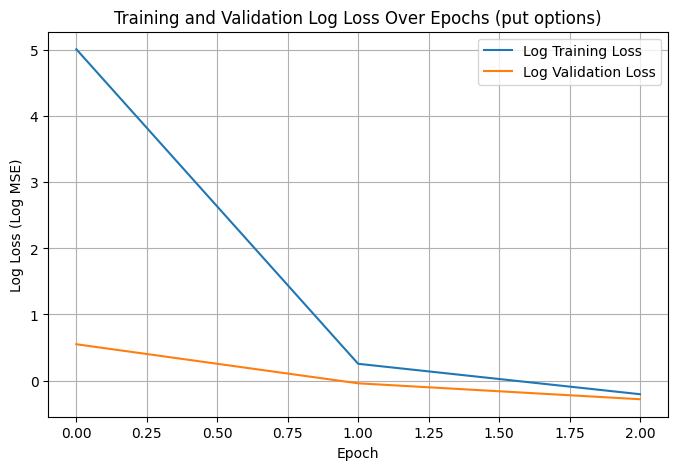

In [13]:
# Plot training and validation loss
plt.figure(figsize=(8,5))

eps = 1e-10  # tiny number to avoid log(0)
plt.plot(np.log(np.array(history.history['loss']) + eps), label='Log Training Loss')
plt.plot(np.log(np.array(history.history['val_loss']) + eps), label='Log Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Log Loss (Log MSE)')
plt.title(f'Training and Validation Log Loss Over Epochs ({option_type} options)')
plt.legend()
plt.grid(True)
plt.show()

# Save the model
model.save(model_file)


# Test random entries

In [14]:
# Test 10 random entries
loaded_model = load_model(model_file)
sample_entries = X.sample(10)
sample_scaled = scaler.transform(sample_entries)
predictions = loaded_model.predict(sample_scaled)

for i, idx in enumerate(sample_entries.index):
    print(f"Entry {idx} - Predicted price: {predictions[i][0]:.2f}, Actual price: {y.loc[idx]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Entry 148442 - Predicted price: 55.80, Actual price: 55.82
Entry 319052 - Predicted price: 55.42, Actual price: 54.28
Entry 909691 - Predicted price: 17.62, Actual price: 17.45
Entry 168426 - Predicted price: 2.04, Actual price: 2.30
Entry 958901 - Predicted price: 17.57, Actual price: 17.52
Entry 872182 - Predicted price: 0.00, Actual price: 0.18
Entry 563606 - Predicted price: 0.00, Actual price: 0.12
Entry 269627 - Predicted price: 3.38, Actual price: 3.20
Entry 103539 - Predicted price: 1.08, Actual price: 1.04
Entry 465906 - Predicted price: 1.86, Actual price: 1.60
